In [1]:
import pandas as pd
import numpy as np
import os as os
import matplotlib.pyplot as plt
%matplotlib inline    
from matplotlib import dates
import warnings
warnings.simplefilter("ignore")
import plotly.express as px
import plotly.graph_objects as go

#Model Selection:
    
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AR,ARResults
from pmdarima import auto_arima
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from fbprophet import Prophet
import lightgbm as lgb

#Model Evaluation & Forecasting:
from statsmodels.tools.eval_measures import mse, rmse, meanabs
from sklearn import metrics 


In [2]:
df = pd.read_csv("cleaned_fuel_data.csv")

### Split the dataset into training and test set

In [3]:
training_dataframe = df.iloc[:len(df)-1095,:]
testing_dataframe = df.iloc[len(df)-1095:, :]

#training_dataframe = df.iloc[0:1826]
#testing_dataframe = df.iloc[1826:2557]


### SARIMA Model

SARIMA is an acronym that stands for Seasonal AutoRegressive Integrated Moving Average; a class of statistical models for analyzing and forecasting time series data when it is seasonal. It is nothing but an extension to ARIMA that supports the direct modeling of the seasonal component of the series.

A standard notation of ARIMA is (p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used. The parameters of the ARIMA model are:

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.

Each of these components is explicitly specified in the model as a parameter. In SARIMA, it further adds three new hyperparameters to specify the autoregression (AR), differencing (I), and moving average (MA) of the seasonal components of the series, as well as an additional parameter for the period of the seasonality.

Therefore in this section, we are essentially trying to identify the order of p,d,q and P, D, Q and m (that is; the order of Auto Regression, Integration, and Moving Average Components along with the seasonal regression, differencing and moving average coefficients ) to be applied over the time-series dataset to fit the SARIMA model.

**ARIMA orders using pmdarima.auto_arima:**

In [4]:
auto_arima(training_dataframe["fuel_burn_actual_total_preverified"],m=14, seasonal = True, error_action = "ignore").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2015
Model:               SARIMAX(0, 1, 3)   Log Likelihood              -21797.614
Date:                Mon, 18 Jul 2022   AIC                          43603.229
Time:                        22:36:11   BIC                          43625.660
Sample:                             0   HQIC                         43611.462
                               - 2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2639      0.015    -17.784      0.000      -0.293      -0.235
ma.L2         -0.2610      0.018    -14.647      0.000      -0.296      -0.226
ma.L3         -0.1334      0.019     -7.092      0.000      -0.170      -0.097
sigma2      1.486e+08   6.05e-12   2.46e+19      0.000    1.49e+08    1.49e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1723.25
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.36
Prob(H) (two-sided):                  0.67   Kurtosis:                         7.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.22e+34. Standard errors may be unstable.
"""

auto_arima suggests that we should fit the following SARIMA model (3,1,5)(2,1,1,12) to best forecast future values of the chosen time series dataset. Let’s try to revalidate the orders through the stepwise AIC Criterion method in the next step.

#### Revalidating ARIMA orders using stepwise auto_arima:

In [5]:
stepwise_fit = auto_arima(training_dataframe["fuel_burn_actual_total_preverified"], start_p = 0
                          , start_q = 0,max_p =3, max_q = 3
                          , m=40, seasonal = True, d=None, 
                          trace = True, 
                          error_action ='ignore'
                          , suppress_warnings = True,
                          stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[40] intercept   : AIC=43881.839, Time=1.39 sec
 ARIMA(0,1,0)(0,0,0)[40] intercept   : AIC=43877.842, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[40] intercept   : AIC=43838.689, Time=1.61 sec
 ARIMA(0,1,1)(0,0,1)[40] intercept   : AIC=43794.989, Time=2.09 sec
 ARIMA(0,1,0)(0,0,0)[40]             : AIC=43875.859, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[40] intercept   : AIC=43793.075, Time=0.17 sec
 ARIMA(0,1,1)(1,0,0)[40] intercept   : AIC=43794.986, Time=2.30 sec
 ARIMA(0,1,1)(1,0,1)[40] intercept   : AIC=43796.839, Time=6.02 sec
 ARIMA(1,1,1)(0,0,0)[40] intercept   : AIC=43617.859, Time=0.45 sec
 ARIMA(1,1,1)(1,0,0)[40] intercept   : AIC=43619.824, Time=5.55 sec
 ARIMA(1,1,1)(0,0,1)[40] intercept   : AIC=43619.798, Time=5.53 sec
 ARIMA(1,1,1)(1,0,1)[40] intercept   : AIC=inf, Time=15.06 sec
 ARIMA(1,1,0)(0,0,0)[40] intercept   : AIC=43836.694, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[40] intercept   : AIC=43607.672, Time=0.41 sec
 ARIMA(2,1

Stepwise auto_arima gives us the breakdown of all the possible ‘Akaike information criterion’ or AIC scores in the list. Stepwise fit has retrieved the same results; highlighting the right order of autoregression, integration, and moving average coefficients to be used while fitting the SARIMA model over the chosen time-series dataset.

#### Fit Sarima model

In [6]:
fitted_SARIMA_model = SARIMAX(training_dataframe["fuel_burn_actual_total_preverified"], order =(0,1,3), seasonal_order = (0,0,0,0))
results = fitted_SARIMA_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:     fuel_burn_actual_total_preverified   No. Observations:                 2015
Model:                               SARIMAX(0, 1, 3)   Log Likelihood              -21797.614
Date:                                Mon, 18 Jul 2022   AIC                          43603.229
Time:                                        22:38:42   BIC                          43625.660
Sample:                                             0   HQIC                         43611.462
                                               - 2015                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2639      0.015    -17.784      0.000      -0.293      -0.235
ma.L2         -0.2610      0.018    -14.647      0.000      -0.296      -0.226
ma.L3         -0.1334      0.019     -7.092      0.000      -0.170      -0.097
sigma2      1.486e+08   6.05e-12   2.46e+19      0.000    1.49e+08    1.49e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1723.25
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.36
Prob(H) (two-sided):                  0.67   Kurtosis:                         7.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.22e+34. Standard errors may be unstable.
"""

### Model Evaluation

In [7]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

def metric_eval(Y_actual, Y_Predicted, name):
    mae = metrics.mean_absolute_error(Y_actual, Y_Predicted)
    rmse = np.sqrt(metrics.mean_squared_error(Y_actual, Y_Predicted))
    mape = MAPE(Y_actual, Y_Predicted)
    d = {'name' : [name],'mae': [mae], 'rmse': [rmse], 'mape' :[mape]}
    return pd.DataFrame.from_dict(d)

In [8]:
# Test eval
start = len(training_dataframe)
end = len(training_dataframe) + len(testing_dataframe) -1
test_SARIMA_predictions = results.predict(start = start, end = end).rename('SARIMA Predictions')
test_eval = metric_eval(testing_dataframe['fuel_burn_actual_total_preverified'], test_SARIMA_predictions, 'sarima_test')


# Train eval
start = 0
end = len(training_dataframe) - 1
train_SARIMA_predictions = results.predict(start = start, end = end).rename('SARIMA Predictions')
train_eval = metric_eval(training_dataframe['fuel_burn_actual_total_preverified'], train_SARIMA_predictions, 'sarima_train')

sarima_eval = pd.concat([train_eval, test_eval])
sarima_eval

name           mae          rmse        mape
0  sarima_train   8340.287334  12140.446005   22.090833
0   sarima_test  39541.384604  45967.778124  141.356455

In [9]:
test_SARIMA_predictions = pd.DataFrame(test_SARIMA_predictions)
test_SARIMA_predictions = test_SARIMA_predictions.join(testing_dataframe)
test_SARIMA_predictions.set_index("gas_date", inplace=True)



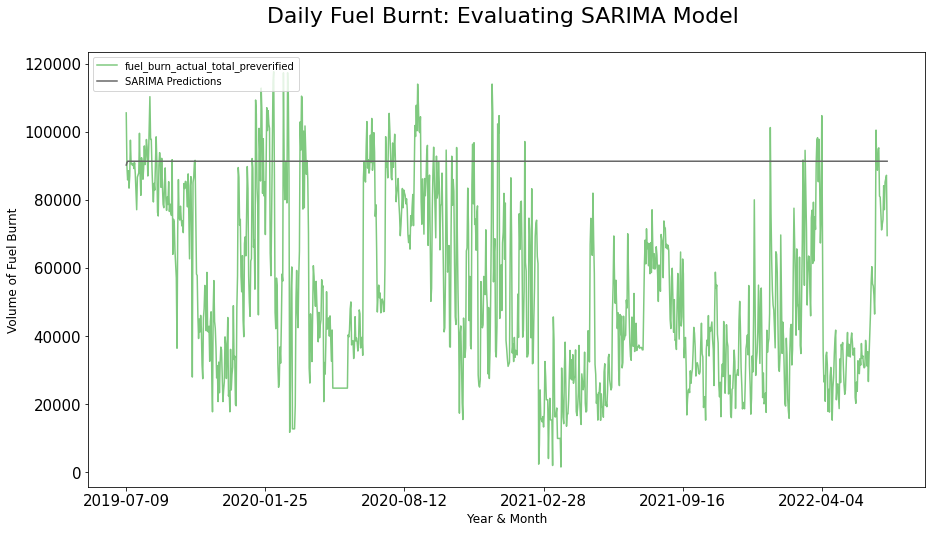

In [10]:

test_SARIMA_predictions[["fuel_burn_actual_total_preverified", "SARIMA Predictions"]] = test_SARIMA_predictions[["fuel_burn_actual_total_preverified", "SARIMA Predictions"]] .astype(int)
ax = test_SARIMA_predictions[["fuel_burn_actual_total_preverified", "SARIMA Predictions"]].plot.line(
                             title = 'Daily Fuel Burnt: Evaluating SARIMA Model', legend =True, table = False, grid = False
                            ,  subplots = False,  figsize =(15,8)
                            , colormap = 'Accent', fontsize = 15
                            ,linestyle='-', stacked=False)

plt.ylabel('Volume of Fuel Burnt',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Year & Month',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
#Set up title, legends and theme:
plt.title('Daily Fuel Burnt: Evaluating SARIMA Model \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc='upper left', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.style.use(['classic'])
ax.autoscale(enable=True, axis='x', tight=False)

In [11]:
train_SARIMA_predictions = pd.DataFrame(train_SARIMA_predictions)
train_SARIMA_predictions = train_SARIMA_predictions.join(training_dataframe)
train_SARIMA_predictions.set_index("gas_date", inplace=True)


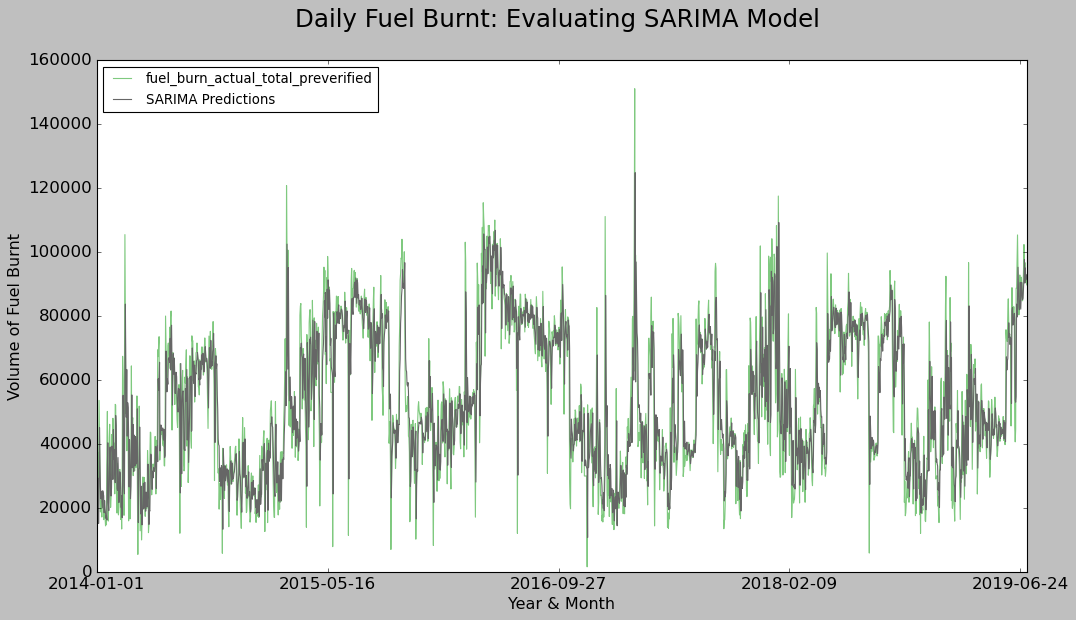

In [12]:
train_SARIMA_predictions[["fuel_burn_actual_total_preverified", "SARIMA Predictions"]] = train_SARIMA_predictions[["fuel_burn_actual_total_preverified", "SARIMA Predictions"]] .astype(int)
ax = train_SARIMA_predictions[["fuel_burn_actual_total_preverified", "SARIMA Predictions"]].plot.line(
                             title = 'Daily Fuel Burnt: Evaluating SARIMA Model', legend =True, table = False, grid = False
                            ,  subplots = False,  figsize =(15,8)
                            , colormap = 'Accent', fontsize = 15
                            ,linestyle='-', stacked=False)

plt.ylabel('Volume of Fuel Burnt',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Year & Month',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
#Set up title, legends and theme:
plt.title('Daily Fuel Burnt: Evaluating SARIMA Model \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc='upper left', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.style.use(['classic'])
ax.autoscale(enable=True, axis='x', tight=False)

### PROPHET MODEL

In [13]:
df1 = df.copy()
df1['gas_date'] = pd.to_datetime(df1['gas_date'])
df1['y'] = df1['fuel_burn_actual_total_preverified']
df1 = df1.rename(columns={'gas_date':'ds'})
df_train  = df1.iloc[0:1826]
df_test = df1.iloc[1826:2557]


# Fitting a Prophet model
model = Prophet( daily_seasonality=True)
model.fit(df_train)
forecast_test = model.predict(df_test[['ds']])
forecast_train = model.predict(df_train[['ds']])

In [14]:
forecast_train = forecast_train[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(df_train, on = 'ds')
forecast_test = forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(df_test, on = 'ds')

In [15]:
test_eval = metric_eval(forecast_test['y'], forecast_test['yhat'], 'prophet_test')
train_eval = metric_eval(forecast_train['y'], forecast_train['yhat'], 'prophet_train')

prophet_eval = pd.concat([train_eval, test_eval])
prophet_eval

name           mae          rmse       mape
0  prophet_train  13713.066540  17848.170679  37.470346
0   prophet_test  19194.046526  23809.545287  39.361975

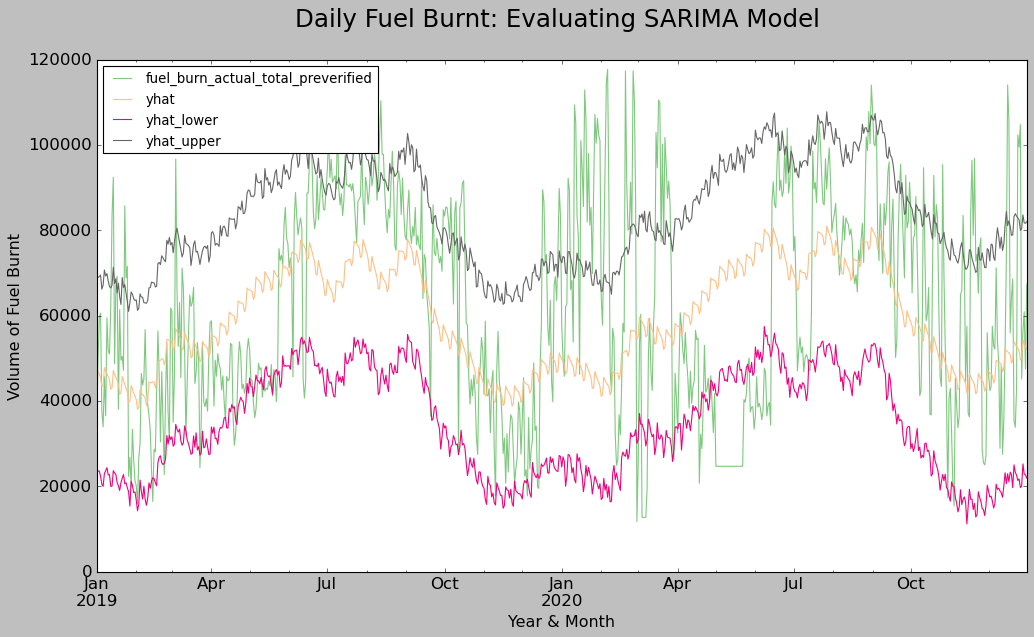

In [16]:
forecast_test.set_index("ds", inplace=True)
forecast_test[['fuel_burn_actual_total_preverified', 'yhat', 'yhat_lower', 'yhat_upper' ]] = \
forecast_test[['fuel_burn_actual_total_preverified', 'yhat', 'yhat_lower', 'yhat_upper']] .astype(int)
ax = forecast_test[['fuel_burn_actual_total_preverified', 'yhat', 'yhat_lower', 'yhat_upper']].plot.line(
                             title = 'Daily Fuel Burnt: Evaluating Prophet Model', legend =True, table = False, grid = False
                            ,  subplots = False,  figsize =(15,8)
                            , colormap = 'Accent', fontsize = 15
                            ,linestyle='-', stacked=False)

plt.ylabel('Volume of Fuel Burnt',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Year & Month',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
#Set up title, legends and theme:
plt.title('Daily Fuel Burnt: Evaluating SARIMA Model \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc='upper left', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.style.use(['classic'])
ax.autoscale(enable=True, axis='x', tight=False)

### Modelling with more features

In [3]:
lag_features = ["fuel_burn_actual_total_preverified"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

In [18]:
df['fuel_diff']=df['fuel_burn_actual_total_preverified']-df['fuel_burn_actual_total_preverified'].shift(1)

In [19]:
fig = go.Figure([go.Scatter(x=df.index,y=df.fuel_diff)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='difference fuel burnt over time ')
fig.show()

In [20]:
df.columns

Index(['gas_date', 'MW_actual_Lewis_Creek1', 'MW_actual_Lewis_Creek2',
       'MW_actual_preverified_Lewis_Creek1',
       'MW_actual_preverified_Lewis_Creek2', 'fuel_burn_actual_Lewis_Creek1',
       'fuel_burn_actual_Lewis_Creek2', 'fuel_burn_actual_total',
       'fuel_burn_actual_total_preverified', 'hdd_actual', 'cdd_actual',
       'temp_actual', 'fuel_burn_actual_total_preverified_mean_lag3',
       'fuel_burn_actual_total_preverified_mean_lag7',
       'fuel_burn_actual_total_preverified_mean_lag30',
       'fuel_burn_actual_total_preverified_std_lag3',
       'fuel_burn_actual_total_preverified_std_lag7',
       'fuel_burn_actual_total_preverified_std_lag30', 'fuel_diff'],
      dtype='object')

#### Time Based Features

In [4]:
df['gas_date'] = pd.to_datetime(df['gas_date'])
df['day'] = df['gas_date'].dt.day
df['week'] = df['gas_date'].dt.week
df['quarter'] = df['gas_date'].dt.quarter
df['month'] = df['gas_date'].dt.month
df['year'] = df['gas_date'].dt.year
df['dayofweek'] = df['gas_date'].dt.dayofweek

In [5]:
df.head(5)

gas_date  MW_actual_Lewis_Creek1  MW_actual_Lewis_Creek2  \
0 2014-01-01                1299.000                     0.0   
1 2014-01-02                2732.129                     0.0   
2 2014-01-03                3445.157                     0.0   
3 2014-01-04                1362.175                     0.0   
4 2014-01-05                2547.000                     0.0   

   MW_actual_preverified_Lewis_Creek1  MW_actual_preverified_Lewis_Creek2  \
0                              1299.0                                -5.0   
1                              2907.0                                -5.0   
2                              3642.0                                -4.0   
3                              1421.0                                -3.0   
4                              2547.0                                -6.0   

   fuel_burn_actual_Lewis_Creek1  fuel_burn_actual_Lewis_Creek2  \
0                    15796.80902                            0.0   
1                    28850.49202                            0.0   
2                    35496.94442                            0.0   
3                    16723.12597                            0.0   
4                    27005.17132                            0.0   

   fuel_burn_actual_total  fuel_burn_actual_total_preverified  hdd_actual  \
0             15796.80902                         15796.80902    2.599623   
1             28850.49202                         30609.25407    2.599623   
2             35496.94442                         37476.68947    2.599623   
3             16723.12597                         17318.48984    2.599623   
4             27005.17132                         27005.17132    2.599623   

   ...  fuel_burn_actual_total_preverified_mean_lag30  \
0  ...                                   53390.265625   
1  ...                                   15796.808594   
2  ...                                   23203.031250   
3  ...                                   27960.917969   
4  ...                                   25300.310547   

   fuel_burn_actual_total_preverified_std_lag3  \
0                                  7976.842285   
1                                  7976.842285   
2                                 10473.980469   
3                                 11079.916992   
4                                 10248.244141   

   fuel_burn_actual_total_preverified_std_lag7  \
0                                 10570.537109   
1                                 10570.537109   
2                                 10473.980469   
3                                 11079.916992   
4                                 10495.635742   

   fuel_burn_actual_total_preverified_std_lag30  day  week  quarter  month  \
0                                  14706.541016    1     1        1      1   
1                                  14706.541016    2     1        1      1   
2                                  10473.980469    3     1        1      1   
3                                  11079.916992    4     1        1      1   
4                                  10495.635742    5     1        1      1   

   year  dayofweek  
0  2014          2  
1  2014          3  
2  2014          4  
3  2014          5  
4  2014          6  

[5 rows x 24 columns]

In [23]:
training_dataframe = df.iloc[:len(df)-1095,:]
testing_dataframe = df.iloc[len(df)-1095:, :]

In [24]:
exogenous_features = ['fuel_burn_actual_total_preverified_mean_lag3', 'fuel_burn_actual_total_preverified_mean_lag7',
                      'fuel_burn_actual_total_preverified_mean_lag30', 'fuel_burn_actual_total_preverified_std_lag3',
                      'fuel_burn_actual_total_preverified_std_lag7', 'fuel_burn_actual_total_preverified_std_lag30',
                      'day', 'week', 'month', 'quarter', 'year', 'dayofweek']

In [25]:
model = auto_arima(training_dataframe.fuel_burn_actual_total_preverified, exogenous=training_dataframe[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(training_dataframe.fuel_burn_actual_total_preverified, exogenous=training_dataframe[exogenous_features])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=43568.915, Time=7.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=44025.365, Time=0.89 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=43577.967, Time=3.55 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=43623.563, Time=3.80 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=57340.240, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=43568.840, Time=6.38 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=43568.577, Time=5.81 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=43567.433, Time=6.86 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=43568.989, Time=7.03 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=43568.860, Time=7.28 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=43570.597, Time=8.01 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=43565.253, Time=6.22 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=43566.577, Time=5.09 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=43567.123, Time=6.47 sec
 ARIMA(0,0,4)(0,0,0

ARIMA(order=(0, 0, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [26]:
# Test eval
start = len(training_dataframe)
end = len(training_dataframe) + len(testing_dataframe) -1

forecast = model.predict(n_periods=len(testing_dataframe), exogenous=testing_dataframe[exogenous_features])
testing_dataframe["Forecast_ARIMAX"] = forecast
test_eval = metric_eval(testing_dataframe['fuel_burn_actual_total_preverified'], forecast, 'sarima_test_exogeneous')



# Train eval
forecast = model.predict(n_periods=len(training_dataframe), exogenous=training_dataframe[exogenous_features])
training_dataframe["Forecast_ARIMAX"] = forecast
train_eval = metric_eval(training_dataframe['fuel_burn_actual_total_preverified'], forecast, 'sarima_train_exogeneous')


sarima_eval = pd.concat([train_eval, test_eval])
sarima_eval

name           mae          rmse       mape
0  sarima_train_exogeneous   9753.501901  13556.345396  26.577792
0   sarima_test_exogeneous  11402.436645  15415.258451  32.146620

<AxesSubplot:>

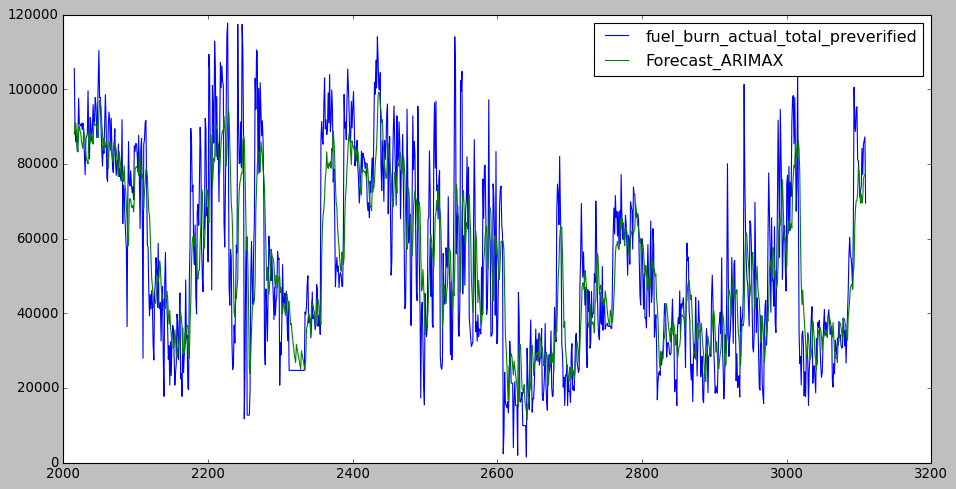

In [27]:
testing_dataframe[["fuel_burn_actual_total_preverified", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

<AxesSubplot:>

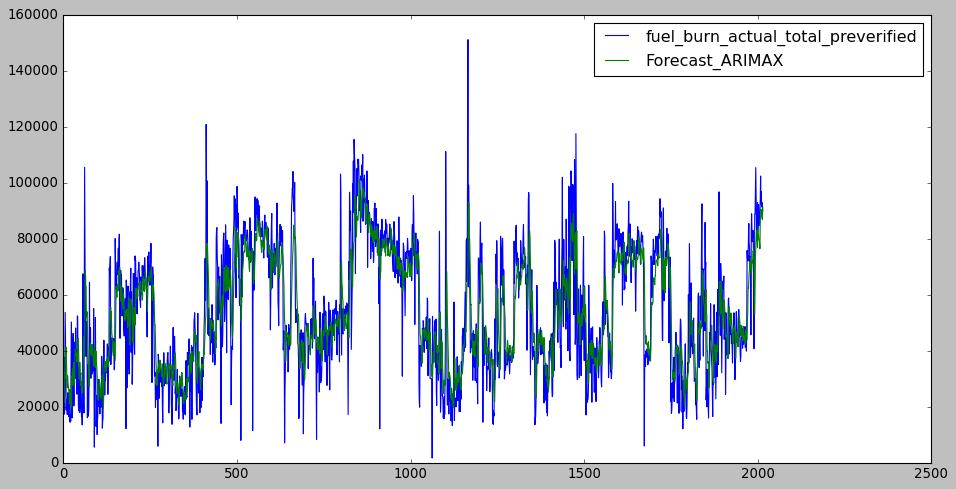

In [28]:
training_dataframe[["fuel_burn_actual_total_preverified", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [29]:
training_dataframe.columns

Index(['gas_date', 'MW_actual_Lewis_Creek1', 'MW_actual_Lewis_Creek2',
       'MW_actual_preverified_Lewis_Creek1',
       'MW_actual_preverified_Lewis_Creek2', 'fuel_burn_actual_Lewis_Creek1',
       'fuel_burn_actual_Lewis_Creek2', 'fuel_burn_actual_total',
       'fuel_burn_actual_total_preverified', 'hdd_actual', 'cdd_actual',
       'temp_actual', 'fuel_burn_actual_total_preverified_mean_lag3',
       'fuel_burn_actual_total_preverified_mean_lag7',
       'fuel_burn_actual_total_preverified_mean_lag30',
       'fuel_burn_actual_total_preverified_std_lag3',
       'fuel_burn_actual_total_preverified_std_lag7',
       'fuel_burn_actual_total_preverified_std_lag30', 'fuel_diff', 'day',
       'week', 'quarter', 'month', 'year', 'dayofweek', 'Forecast_ARIMAX'],
      dtype='object')

### Prophet Model

In [30]:
model_fbp = Prophet(daily_seasonality=True)
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(training_dataframe[["gas_date", "fuel_burn_actual_total_preverified"] + exogenous_features].rename(columns={"gas_date": "ds", "fuel_burn_actual_total_preverified": "y"}))

forecast = model_fbp.predict(testing_dataframe[["gas_date", "fuel_burn_actual_total_preverified"] + exogenous_features].rename(columns={"gas_date": "ds"}))
testing_dataframe["Forecast_Prophet"] = forecast.yhat.values

forecast = model_fbp.predict(training_dataframe[["gas_date", "fuel_burn_actual_total_preverified"] + exogenous_features].rename(columns={"gas_date": "ds", "fuel_burn_actual_total_preverified": "y"}))
training_dataframe["Forecast_Prophet"] = forecast.yhat.values

In [31]:
train_eval = metric_eval(training_dataframe['fuel_burn_actual_total_preverified'], training_dataframe["Forecast_Prophet"], 'prophet_train_exogeneous')
test_eval = metric_eval(testing_dataframe['fuel_burn_actual_total_preverified'], testing_dataframe["Forecast_Prophet"], 'prophet_test_exogeneous')
prophet_eval = pd.concat([train_eval, test_eval])
prophet_eval

name           mae          rmse       mape
0  prophet_train_exogeneous   9347.454372  13070.551264  25.026194
0   prophet_test_exogeneous  11307.673432  15135.550688  32.661165

<AxesSubplot:>

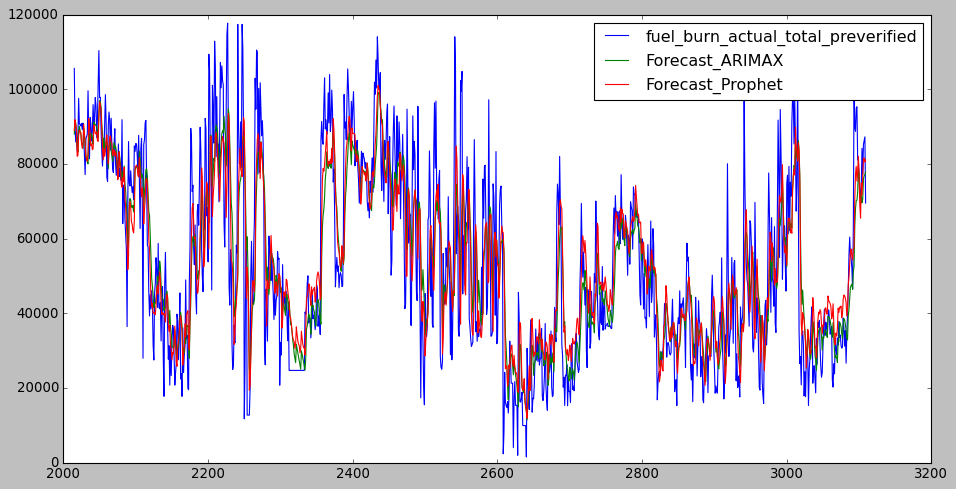

In [32]:
testing_dataframe[["fuel_burn_actual_total_preverified", "Forecast_ARIMAX", "Forecast_Prophet"]].plot(figsize=(14, 7))

### LIGHTGBM

In [33]:
params = {"objective": "regression"}

dtrain = lgb.Dataset(training_dataframe[exogenous_features], label=training_dataframe.fuel_burn_actual_total_preverified.values)
dvalid = lgb.Dataset(testing_dataframe[exogenous_features])

model_lgb = lgb.train(params, train_set=dtrain)

forecast = model_lgb.predict(testing_dataframe[exogenous_features])
testing_dataframe["Forecast_LightGBM"] = forecast

forecast = model_lgb.predict(training_dataframe[exogenous_features])
training_dataframe["Forecast_LightGBM"] = forecast

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1648
[LightGBM] [Info] Number of data points in the train set: 2015, number of used features: 12
[LightGBM] [Info] Start training from score 53775.449695


In [34]:
train_eval = metric_eval(training_dataframe['fuel_burn_actual_total_preverified'], training_dataframe["Forecast_LightGBM"], 'LightGBM_train_exogeneous')
test_eval = metric_eval(testing_dataframe['fuel_burn_actual_total_preverified'], testing_dataframe["Forecast_LightGBM"], 'LightGBM_test_exogeneous')
lighgbm_eval = pd.concat([train_eval, test_eval])
lighgbm_eval

name           mae          rmse       mape
0  LightGBM_train_exogeneous   4920.624688   6812.725663  13.268017
0   LightGBM_test_exogeneous  11627.509689  15697.147357  34.972515

### Training Plot

<AxesSubplot:>

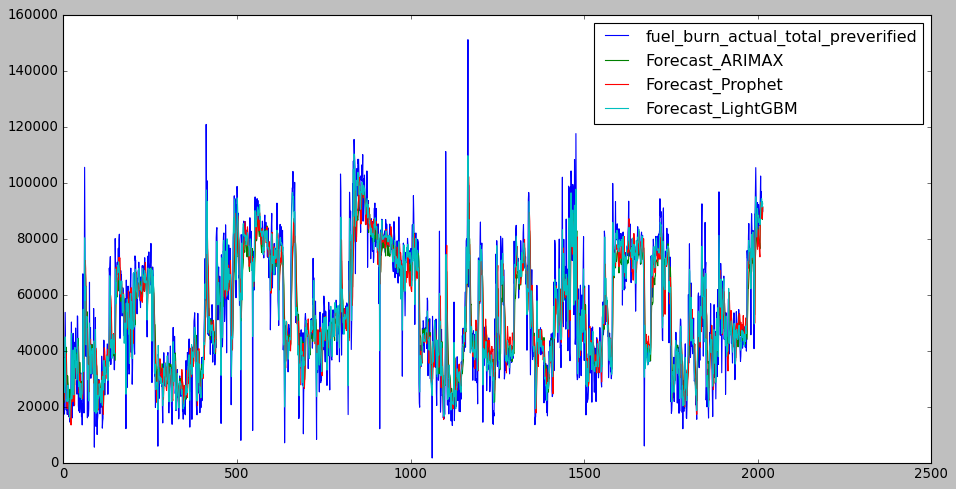

In [35]:
training_dataframe[["fuel_burn_actual_total_preverified", "Forecast_ARIMAX", "Forecast_Prophet", "Forecast_LightGBM"]].plot(figsize=(14, 7))

### Testing Plot

<AxesSubplot:>

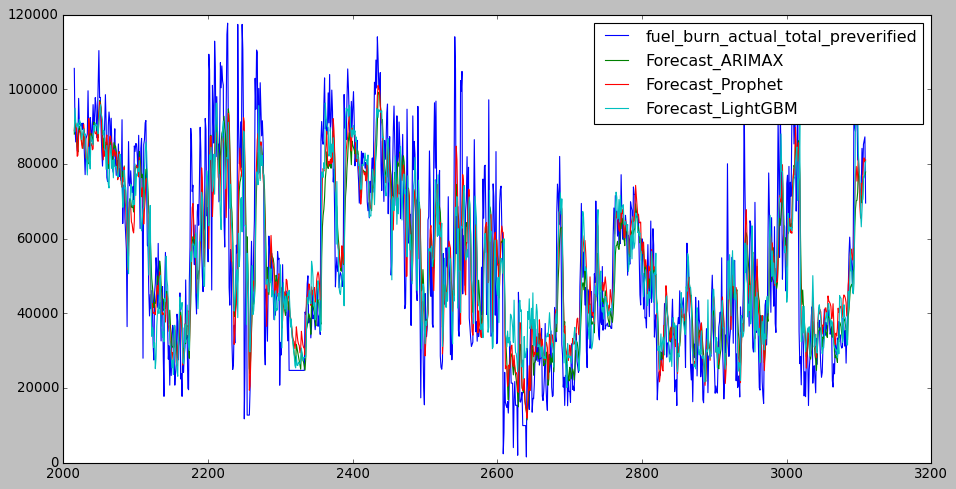

In [36]:
testing_dataframe[["fuel_burn_actual_total_preverified", "Forecast_ARIMAX", "Forecast_Prophet", "Forecast_LightGBM"]].plot(figsize=(14, 7))

### Ensemble Model

In [45]:
training_dataframe['Forecast_ensemble'] = training_dataframe[['Forecast_ARIMAX', 'Forecast_Prophet', 'Forecast_LightGBM']].mean(axis=1)
testing_dataframe['Forecast_ensemble'] = testing_dataframe[['Forecast_ARIMAX', 'Forecast_Prophet', 'Forecast_LightGBM']].mean(axis=1)
train_eval = metric_eval(training_dataframe['fuel_burn_actual_total_preverified'], training_dataframe["Forecast_ensemble"], 'Ensemble_train_exogeneous')
test_eval = metric_eval(testing_dataframe['fuel_burn_actual_total_preverified'], testing_dataframe["Forecast_ensemble"], 'Ensemble_test_exogeneous')
ensemble_eval = pd.concat([train_eval, test_eval])
ensemble_eval

name           mae          rmse       mape
0  Ensemble_train_exogeneous   7754.604669  10826.312624  21.081700
0   Ensemble_test_exogeneous  11152.123749  15031.649522  32.625484

In [39]:
final_df = pd.concat([training_dataframe,testing_dataframe])

In [41]:
final_df['Forecast_ensemble'] = final_df[['Forecast_ARIMAX', 'Forecast_Prophet', 'Forecast_LightGBM']].mean(axis=1)
final_df.head()

gas_date  MW_actual_Lewis_Creek1  MW_actual_Lewis_Creek2  \
0 2014-01-01                1299.000                     0.0   
1 2014-01-02                2732.129                     0.0   
2 2014-01-03                3445.157                     0.0   
3 2014-01-04                1362.175                     0.0   
4 2014-01-05                2547.000                     0.0   

   MW_actual_preverified_Lewis_Creek1  MW_actual_preverified_Lewis_Creek2  \
0                              1299.0                                -5.0   
1                              2907.0                                -5.0   
2                              3642.0                                -4.0   
3                              1421.0                                -3.0   
4                              2547.0                                -6.0   

   fuel_burn_actual_Lewis_Creek1  fuel_burn_actual_Lewis_Creek2  \
0                    15796.80902                            0.0   
1                    28850.49202                            0.0   
2                    35496.94442                            0.0   
3                    16723.12597                            0.0   
4                    27005.17132                            0.0   

   fuel_burn_actual_total  fuel_burn_actual_total_preverified  hdd_actual  \
0             15796.80902                         15796.80902    2.599623   
1             28850.49202                         30609.25407    2.599623   
2             35496.94442                         37476.68947    2.599623   
3             16723.12597                         17318.48984    2.599623   
4             27005.17132                         27005.17132    2.599623   

   ...  day  week  quarter  month  year  dayofweek  Forecast_ARIMAX  \
0  ...    1     1        1      1  2014          2     55662.183085   
1  ...    2     1        1      1  2014          3     21370.895459   
2  ...    3     1        1      1  2014          4     29209.098952   
3  ...    4     1        1      1  2014          5     32280.161652   
4  ...    5     1        1      1  2014          6     29959.060818   

   Forecast_Prophet  Forecast_LightGBM  ensemble_model  
0      55117.248382       28501.997041    46427.142836  
1      22270.084727       30366.669004    24669.216397  
2      28252.763224       37080.883730    31514.248635  
3      29704.230132       25046.024253    29010.138679  
4      30056.260777       29310.294939    29775.205511  

[5 rows x 29 columns]

In [47]:
final_df[['gas_date', 'fuel_burn_actual_total_preverified','Forecast_ARIMAX', 'Forecast_Prophet', 'Forecast_LightGBM', 'Forecast_ensemble']].to_csv('Forecast.csv', index=False)

In [6]:
df.to_csv("modelling_data.csv", index=False)